In [32]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



def format_data(data, sample_name=None):
    '''Return data each size and heigh by row
       | Allele1 | Allel2 | Size1 | Size 2 | Height1 | Height2 |

       ------------------------------
       | Allele  | Size  | Height   |
       ------------------------------
         Allele1 | Size1 | Height 1 | 
         Allele2 | Size2 | Height 2 |
    '''
    # selected colums
    cols = ['Marker', 'Allele 1', 'Allele 2', 'Size 1', 'Size 2', 'Height 1', 'Height 2']

    if sample_name:
        tmp = data[data['Sample Name'] == sample_name]
    else:
        tmp = data.copy()

    # reformat table to long format

    df = pd.wide_to_long(tmp[cols], 
                        stubnames=['Allele', 'Size', "Height"],
                        i='Marker',
                        j = 'AlleleNumber', sep=" ").reset_index().sort_values('Marker')
    df = df[pd.notna(df.Size)].sort_values(['Marker', 'AlleleNumber']).reset_index(drop=True)

    return df



def load_def_table(def_file, table_name='marker_table'):

    return pickle.load(open(def_file, 'rb'))[table_name]




def generate_marker_table(marker_table):   
    marker_table = marker_table[['marker', 'star_allele', 'rsid', 'nt_change']]

    marker_table['gene'] = marker_table.marker.apply(lambda x: x[:-4])

    def generate_label(df):
        sep = '\n'
        if df.star_allele != '-':
            label = f'{df.gene}{sep}{df.star_allele}'
        elif df.rsid != '':
            label = f'{df.gene}{sep}{df.rsid}'
        else:
            label = f'{df.gene}{sep}{df.nt_change}'

        return label

    marker_table['label'] = marker_table.apply(generate_label,axis=1)

    return marker_table[['marker', 'label']]


# def load_bin_data()

def load_bin_file(bin_file, def_file, sample_name):
    '''
    Load bin file and match with def table to make label
    '''
    
    bin_data = pd.read_csv(bin_file, sep='\t')
    bin_data = format_data(bin_data, sample_name)

    marker_table = load_def_table(def_file)
    marker_table = marker_table[marker_table.marker.isin(bin_data['Marker'].tolist())]
    marker_table = generate_marker_table(marker_table)
    marker_table.columns = ['Marker', 'Label']

    bin_data = bin_data.merge(marker_table, how='left', on='Marker')
    bin_data['Label'].fillna('NA')

    return bin_data



def generate_intensity(size, height):

    '''Generate intensity base on height of each allele'''
    
    # generate width based on height

    range = 2.5 if height < 10000 else 2.7
        
    width = np.arange(-1*range,range,0.01)

    intensity = height*np.exp(-15*np.log(1+(width**2)/10))

    # set 100 first and last intensity = 0
    intensity[0] = 0
    intensity[-1] = 0
    
    return width, intensity


def plot(data, xlim =(20,80), 
         figsize =(15,5),
         dpi = 200,
         color_map = {'A':'green', 'G':'blue', 'T':'red', 'C':'black'},
         alpha = 0.9,
         marker_labels=True,
         ex_height = 500,
         ex_annotation = 200):
    data = data.sort_values('Height')
    max_height = np.max(data.Height)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.set_xlim(*xlim)
    ax.set_ylim(0, max_height + ex_height)
    ax.grid(linestyle='--', alpha = 0.3, color ='gray', linewidth = 0.3)

    for idx, row in data.iterrows():

        width, y = generate_intensity(row.Size, row.Height)

        x = width + row.Size
        
        ax.fill(x, y, color=color_map.get(row.Allele), alpha=alpha)

    # process marker information
    props = dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.5)
    if marker_labels:
        tmp = data.groupby(['Marker', 'Label'], as_index=False).agg({'Size':np.average, 'Height':np.max})

        for _, row in tmp.iterrows():
            ax.text(row.Size,
                    row.Height + ex_annotation,
                    row.Label, 
                    ha='center',
                    fontsize = 11,
                    bbox=props)

    plt.tight_layout()
    plt.show()
            
 

In [41]:
bin_data = pd.read_csv(bin_file, '\t')
marker_table = load_def_table(def_file)
marker_table = marker_table[marker_table.marker.isin(bin_data['Marker'].tolist())]
# marker_table = generate_marker_table(marker_table)

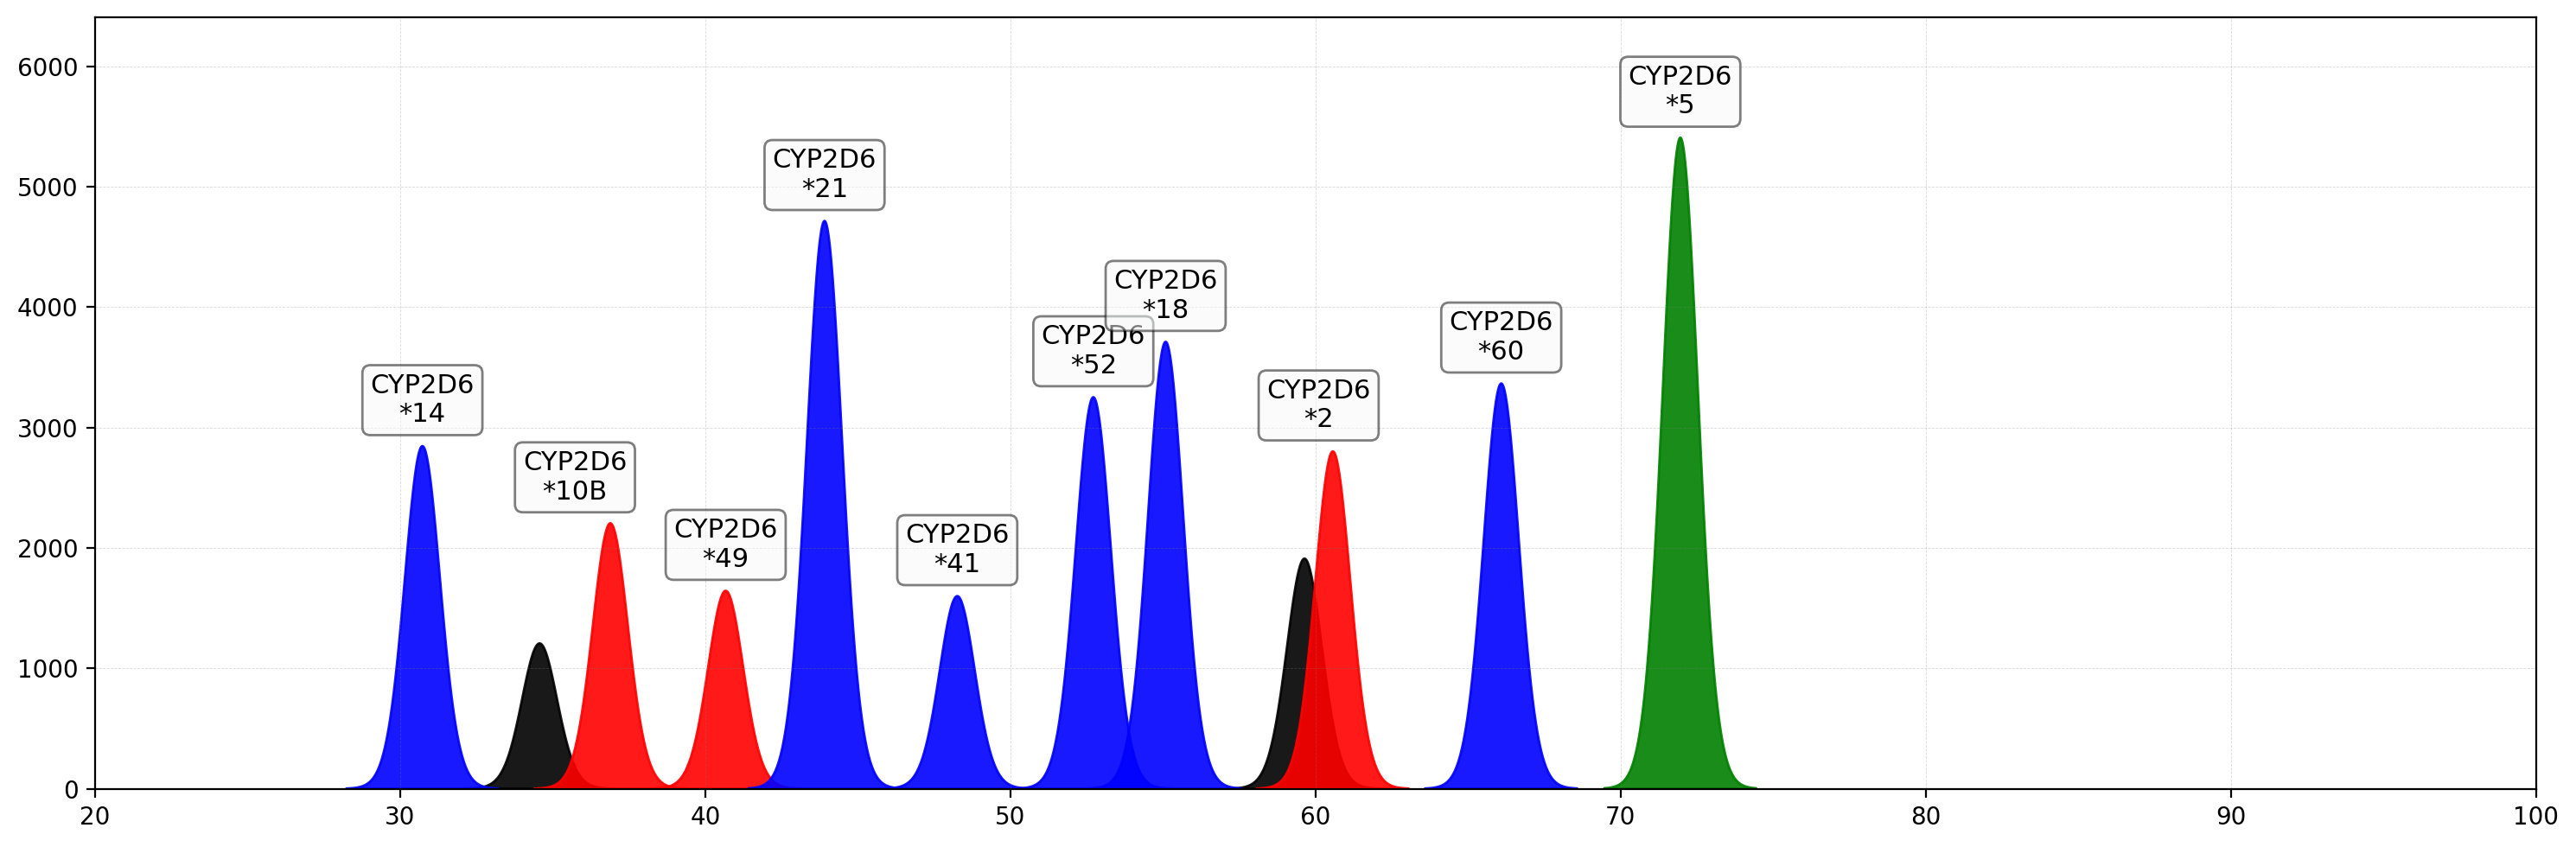

In [49]:
bin_file = './raw_data/bin_text/2020-08-bin-test.txt'
def_file = './resource/tables.pdata'
sample_name = '20200617-630034_S1'
plot(load_bin_file(bin_file, def_file, sample_name), marker_labels=True, xlim=(20, 100), ex_height=1000)

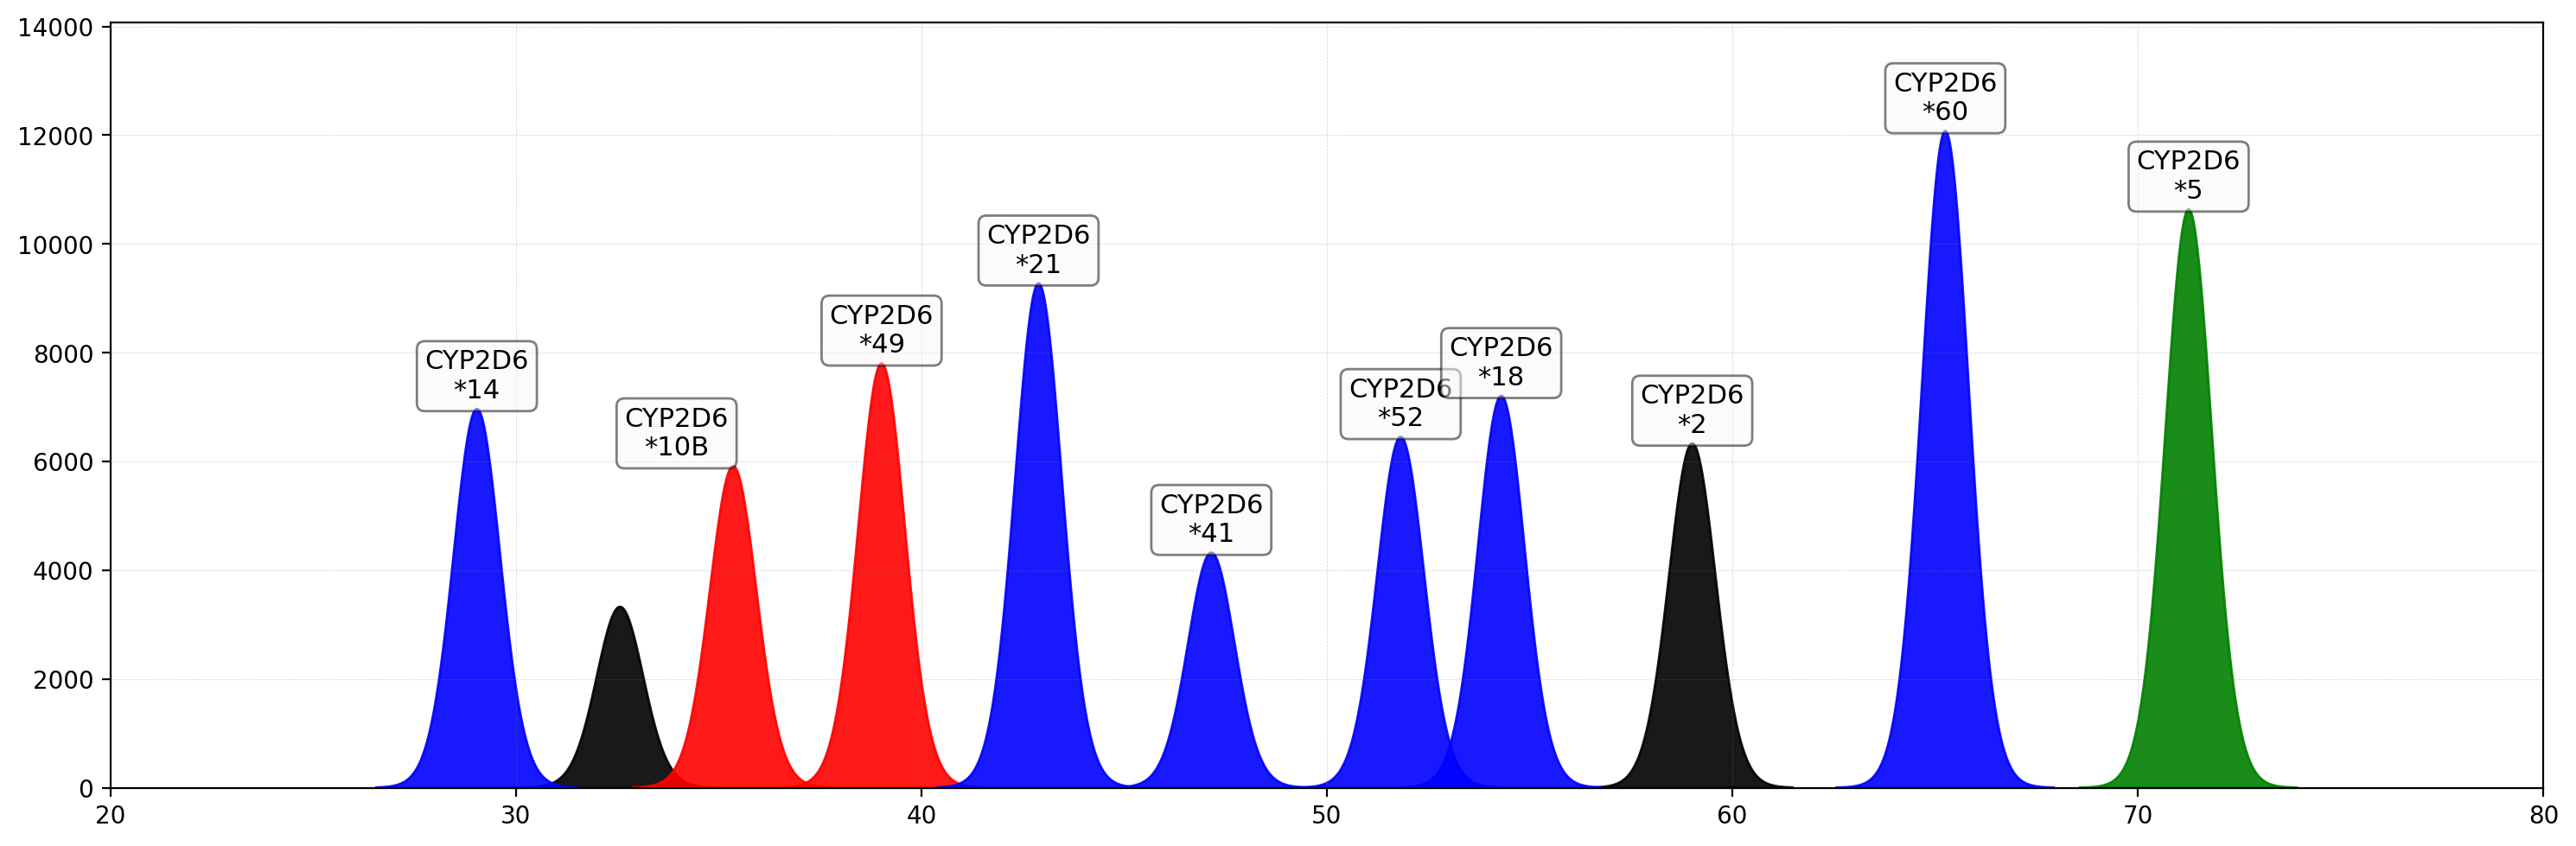

In [50]:
bin_file = './raw_data/bin_text/PA180404A_CYP2D6_Example.txt'
def_file = './resource/tables.pdata'
sample_name = 'S1-20180328-230857'
plot(load_bin_file(bin_file, def_file, sample_name), marker_labels=True, xlim=(20, 80), ex_height=2000)